**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Random Forest Model interpretation

In [161]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [163]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [164]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [165]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [166]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def get_scores(m, config=None):
    res = {
        'config': [config],
        'rmse_train': [rmse(m.predict(X_train), y_train)],
        'rmse_dev': [rmse(m.predict(X_valid), y_valid)],
        'r2_train': [m.score(X_train, y_train)],
        'r2_dev': [m.score(X_valid, y_valid)],
        'r2_oob': [None],
        'n_trees':[m.n_estimators],
        'train_size': [len(y_train)],
        'dev_size': [len(y_valid)],
    }
    if hasattr(m, 'oob_score_'): res['r2_oob'][0] = m.oob_score_
    return pd.DataFrame(res)

In [167]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,0,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,0,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,1,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,-1,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,-1,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [168]:
set_rf_samples(50000)

In [169]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [170]:
results = get_scores(m, 'baseline-subsample-tuning')
results

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.205304,0.248886,0.911909,0.889376,0.894985,40,389125,12000


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [171]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.2 s, sys: 6.24 ms, total: 1.21 s
Wall time: 1.21 s


(9.306625830201313, 0.39408661133993544)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [172]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 67.3 ms, sys: 53.6 ms, total: 121 ms
Wall time: 368 ms


(9.306625830201313, 0.39408661133993544)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

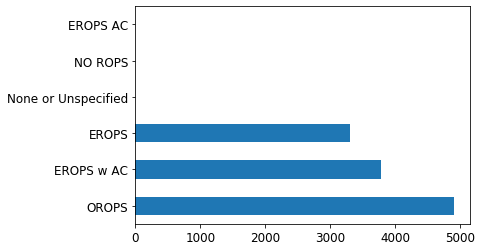

In [173]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [174]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.838190,0.270593
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.574664,0.265479
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682885,0.224142


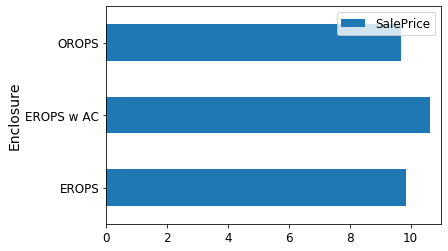

In [175]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

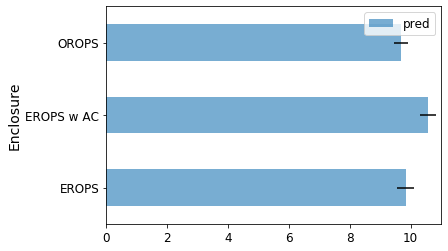

In [176]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

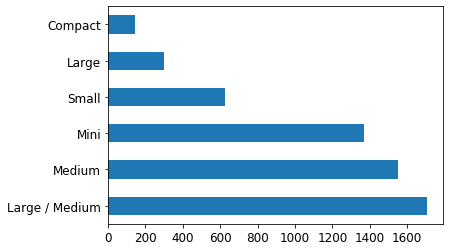

In [177]:
raw_valid.ProductSize.value_counts().plot.barh();

In [178]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.881266,0.367417
Large,10.470589,10.388391,0.357064
Large / Medium,10.691871,10.643997,0.295527
Medium,10.681511,10.623054,0.282550
Mini,9.535147,9.556876,0.247715
Small,10.324448,10.322451,0.297070


In [179]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.037183
Large             0.034371
Small             0.028779
Large / Medium    0.027765
Medium            0.026598
Mini              0.025920
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [180]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.172169
37,Coupler_System,0.107113
13,ProductSize,0.096812
14,fiProductClassDesc,0.082274
2,ModelID,0.052576
10,fiSecondaryDesc,0.051578
63,saleElapsed,0.049955
39,Hydraulics_Flow,0.040052
38,Grouser_Tracks,0.036443
19,Enclosure,0.035305


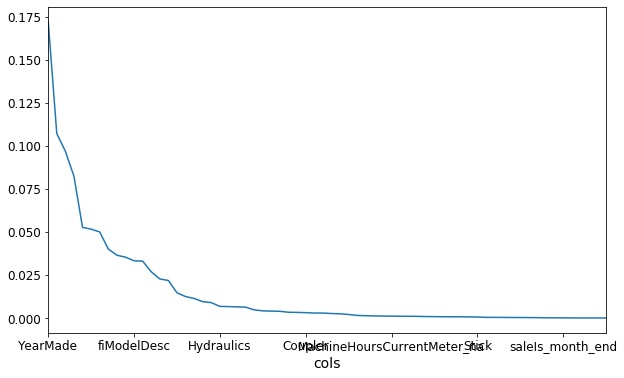

In [181]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [182]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

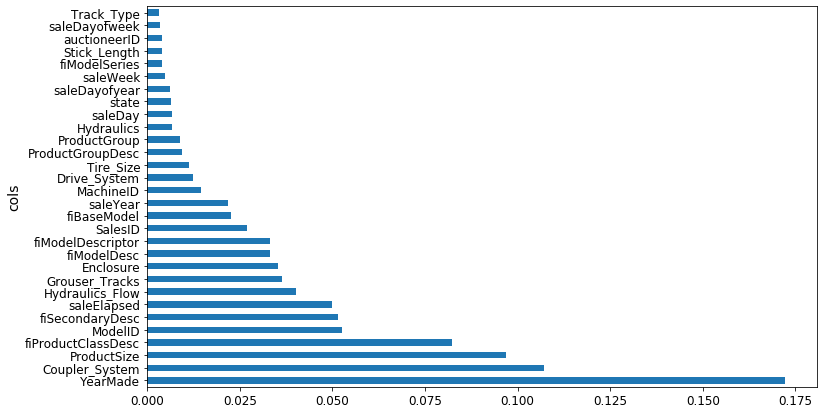

In [183]:
plot_fi(fi[:30]);

In [184]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

24

In [185]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [186]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [187]:
tmp = get_scores(m, 'fi')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,fi,0.207078,0.24476,0.91038,0.893013,0.893957,40,389125,12000


In [188]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.205304,0.248886,0.911909,0.889376,0.894985,40,389125,12000
0,fi,0.207078,0.244760,0.910380,0.893013,0.893957,40,389125,12000


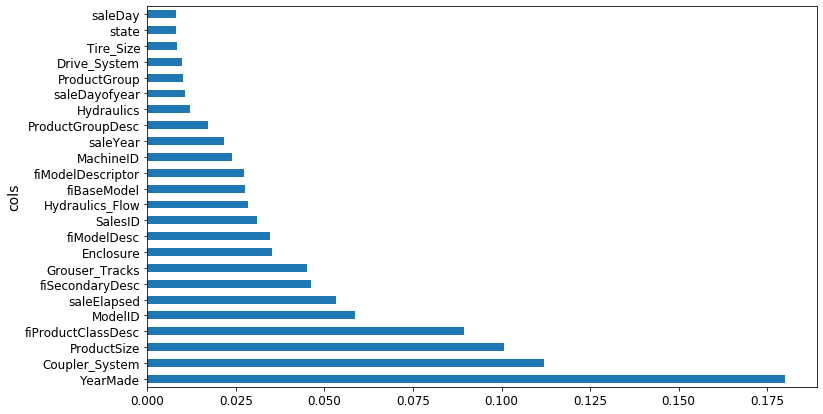

In [189]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## One-hot encoding

proc_df's optional *max_n_cat* argument will turn some categorical variables into new columns.

For example, the column **ProductSize** which has 6 categories:

* Large
* Large / Medium
* Medium
* Compact
* Small
* Mini

gets turned into 6 new columns:

* ProductSize_Large
* ProductSize_Large / Medium
* ProductSize_Medium
* ProductSize_Compact
* ProductSize_Small
* ProductSize_Mini

and the column **ProductSize** gets removed.

It will only happen to columns whose number of categories is no bigger than the value of the *max_n_cat* argument.

Now some of these new columns may prove to have more important features than in the earlier situation, where all categories were in one column.

In [190]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [191]:
tmp = get_scores(m, 'one-hot')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,one-hot,0.207339,0.254417,0.910154,0.884405,0.892487,40,389125,12000


In [192]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.205304,0.248886,0.911909,0.889376,0.894985,40,389125,12000
0,fi,0.207078,0.244760,0.910380,0.893013,0.893957,40,389125,12000
0,one-hot,0.207339,0.254417,0.910154,0.884405,0.892487,40,389125,12000


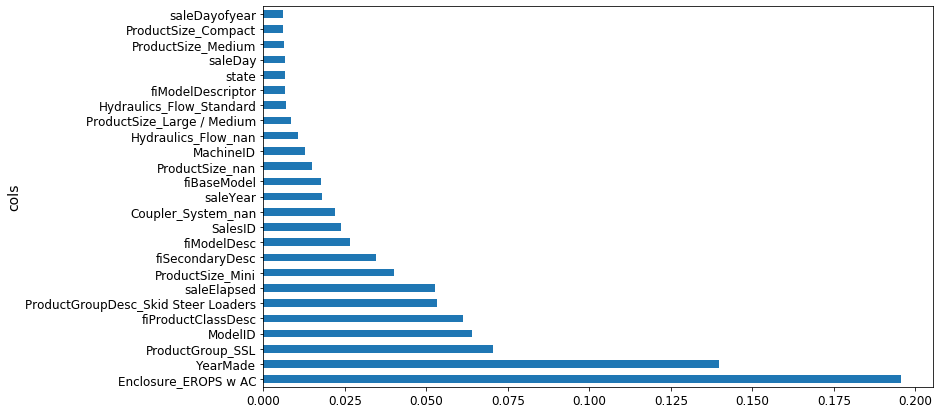

In [193]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [194]:
from scipy.cluster import hierarchy as hc

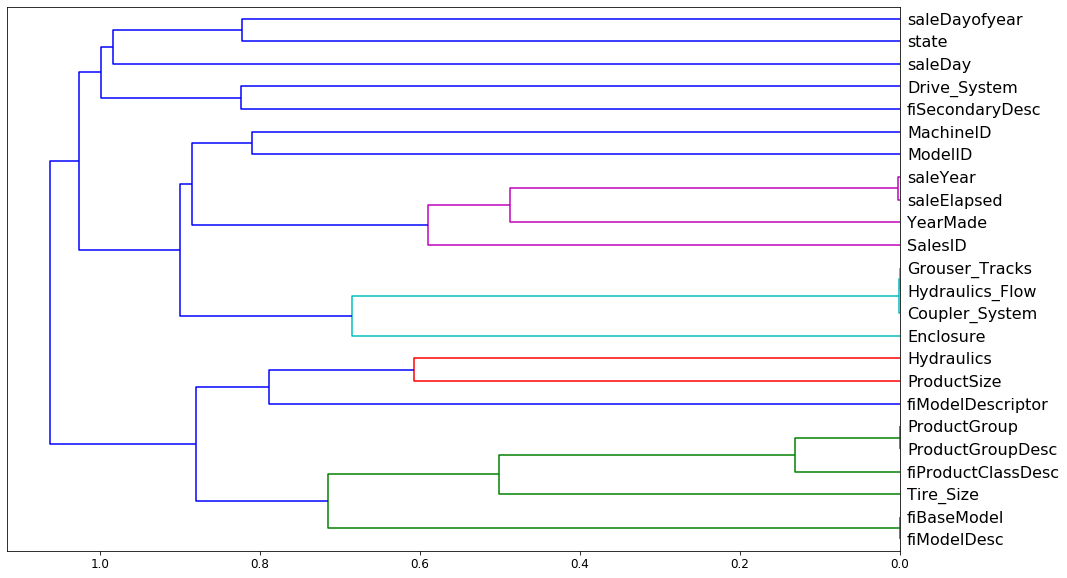

In [195]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [196]:
sorted(list(df_keep.columns))

['Coupler_System',
 'Drive_System',
 'Enclosure',
 'Grouser_Tracks',
 'Hydraulics',
 'Hydraulics_Flow',
 'MachineID',
 'ModelID',
 'ProductGroup',
 'ProductGroupDesc',
 'ProductSize',
 'SalesID',
 'Tire_Size',
 'YearMade',
 'fiBaseModel',
 'fiModelDesc',
 'fiModelDescriptor',
 'fiProductClassDesc',
 'fiSecondaryDesc',
 'saleDay',
 'saleDayofyear',
 'saleElapsed',
 'saleYear',
 'state']

In [197]:
len(corr), len(corr[0])

(24, 24)

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [198]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [199]:
get_oob(df_keep)

0.8902462559251371

Now we try removing each variable one at a time.

In [200]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.889813571955369
saleElapsed 0.8872014021213587
fiModelDesc 0.8883654241893959
fiBaseModel 0.8894927484514016
Grouser_Tracks 0.8904668217892368
Coupler_System 0.8898335461331336


It looks like we can try one from each group for removal. Let's see what that does.

In [201]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8892139217939907

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [202]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [203]:
# np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [204]:
# keep_cols = np.load('tmp/keep_cols.npy')
# df_keep = df_trn[keep_cols]
keep_cols = df_keep.columns

In [209]:
sorted(list(keep_cols))

['Coupler_System',
 'Drive_System',
 'Enclosure',
 'Hydraulics',
 'Hydraulics_Flow',
 'MachineID',
 'ModelID',
 'ProductGroup',
 'ProductGroupDesc',
 'ProductSize',
 'SalesID',
 'Tire_Size',
 'YearMade',
 'fiModelDesc',
 'fiModelDescriptor',
 'fiProductClassDesc',
 'fiSecondaryDesc',
 'saleDay',
 'saleDayofyear',
 'saleElapsed',
 'state']

And let's see how this model looks on the full dataset.

In [205]:
reset_rf_samples()

In [206]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [207]:
tmp = get_scores(m, 'baseline-slow-dedup')
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-dedup,0.125889,0.228204,0.966878,0.906998,0.908479,40,389125,12000


In [208]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.205304,0.248886,0.911909,0.889376,0.894985,40,389125,12000
0,fi,0.207078,0.244760,0.910380,0.893013,0.893957,40,389125,12000
0,one-hot,0.207339,0.254417,0.910154,0.884405,0.892487,40,389125,12000
0,baseline-slow-dedup,0.125889,0.228204,0.966878,0.906998,0.908479,40,389125,12000


# Partial dependence

In [210]:
from pdpbox import pdp
from plotnine import *

In [211]:
set_rf_samples(50000)

This next analysis will be a little easier if we use the 1-hot encoded categorical variables, so let's load them up again.

In [212]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

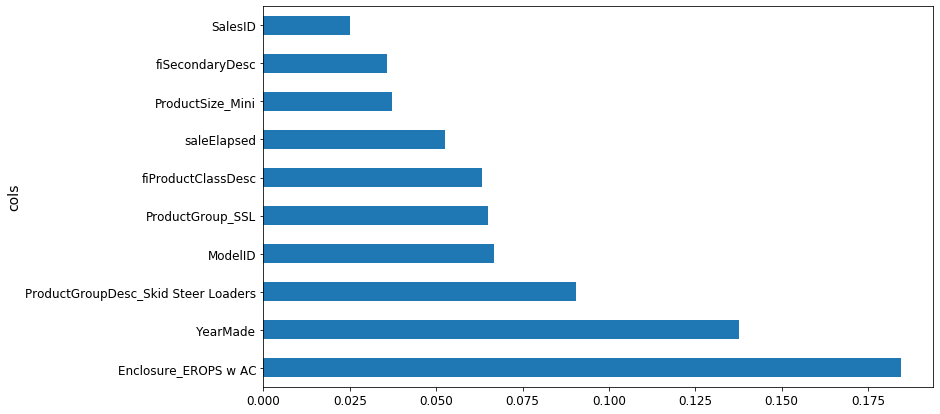

In [213]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

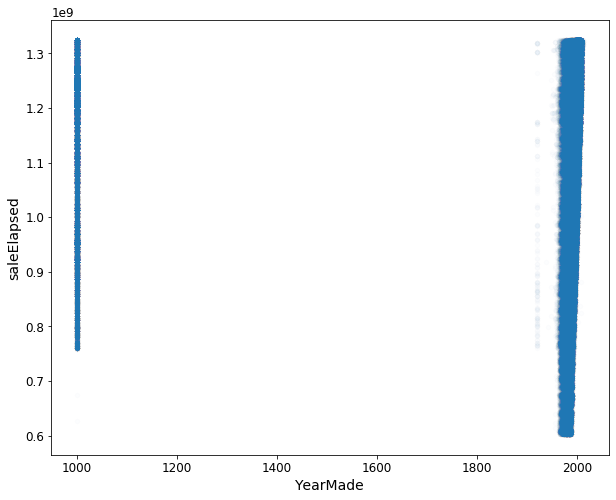

In [214]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [215]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

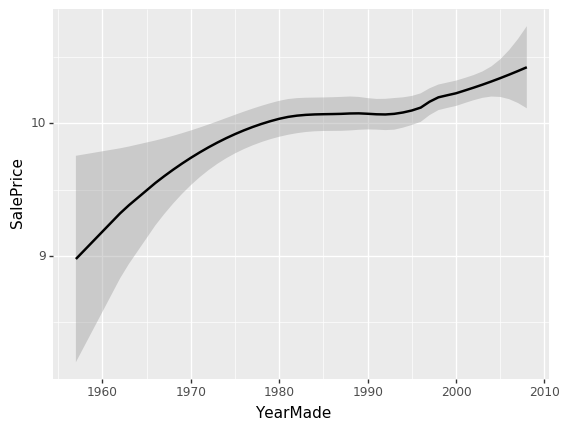

<ggplot: (7032366007)>

In [216]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [217]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [218]:
def plot_pdp_old(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [219]:
def plot_pdp(feat, clusters = None, feat_name = None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature = feat, model_features = x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines = True,
                        cluster = clusters is not None,
                        n_cluster_centers = clusters)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a32705278>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3270c048>})

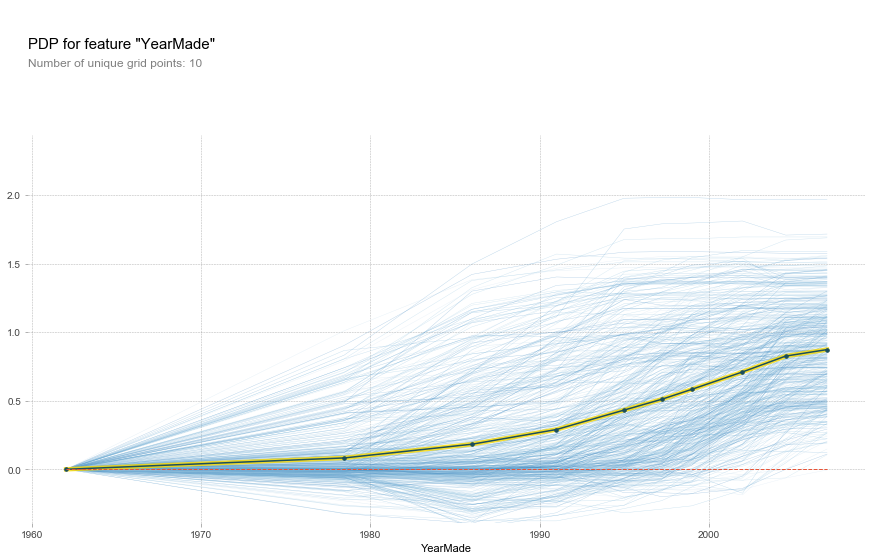

In [220]:
plot_pdp('YearMade')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a4013ab38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a4011dcc0>})

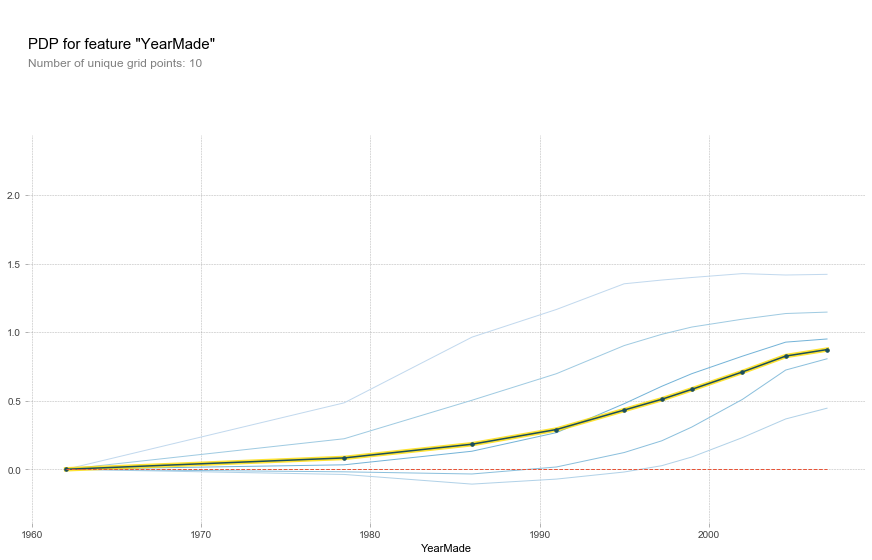

In [221]:
plot_pdp('YearMade', clusters=5)

In [223]:
sorted(list(x.columns))

['Backhoe_Mounting_None or Unspecified',
 'Backhoe_Mounting_Yes',
 'Backhoe_Mounting_nan',
 'Blade_Extension_None or Unspecified',
 'Blade_Extension_Yes',
 'Blade_Extension_nan',
 'Blade_Type',
 "Blade_Width_12'",
 "Blade_Width_13'",
 "Blade_Width_14'",
 "Blade_Width_16'",
 "Blade_Width_<12'",
 'Blade_Width_None or Unspecified',
 'Blade_Width_nan',
 'Coupler_Hydraulic',
 'Coupler_Manual',
 'Coupler_None or Unspecified',
 'Coupler_System_None or Unspecified',
 'Coupler_System_Yes',
 'Coupler_System_nan',
 'Coupler_nan',
 'Differential_Type_Limited Slip',
 'Differential_Type_Locking',
 'Differential_Type_No Spin',
 'Differential_Type_Standard',
 'Differential_Type_nan',
 'Drive_System_All Wheel Drive',
 'Drive_System_Four Wheel Drive',
 'Drive_System_No',
 'Drive_System_Two Wheel Drive',
 'Drive_System_nan',
 'Enclosure_EROPS',
 'Enclosure_EROPS AC',
 'Enclosure_EROPS w AC',
 'Enclosure_NO ROPS',
 'Enclosure_None or Unspecified',
 'Enclosure_OROPS',
 'Enclosure_Type_High Profile',
 'Encl

ignore errors


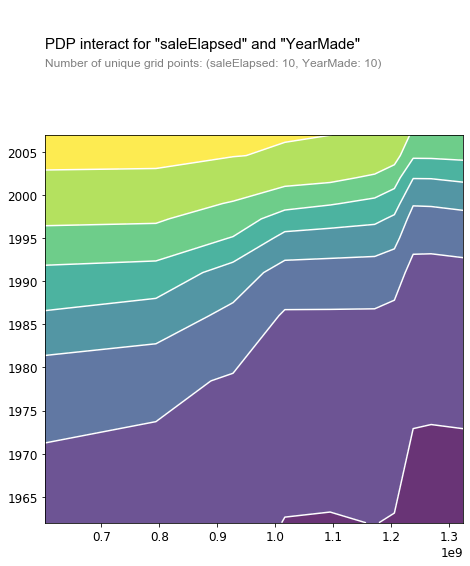

In [229]:
try:
    feats = ['saleElapsed', 'YearMade']
    p = pdp.pdp_interact(m, x, x.columns, feats)
    pdp.pdp_interact_plot(p, feats)
except:
    print("ignore errors")

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a35280828>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3529c438>})

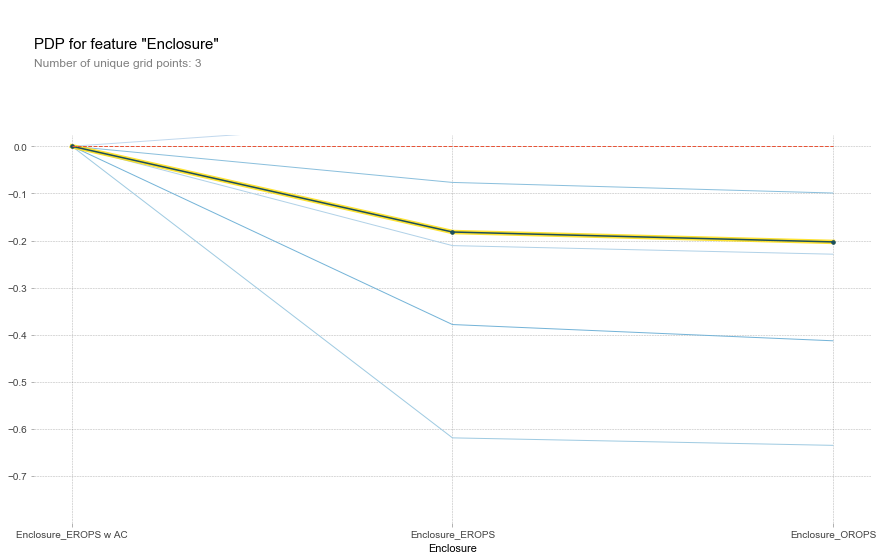

In [230]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [231]:
df_raw.YearMade[df_raw.YearMade<1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

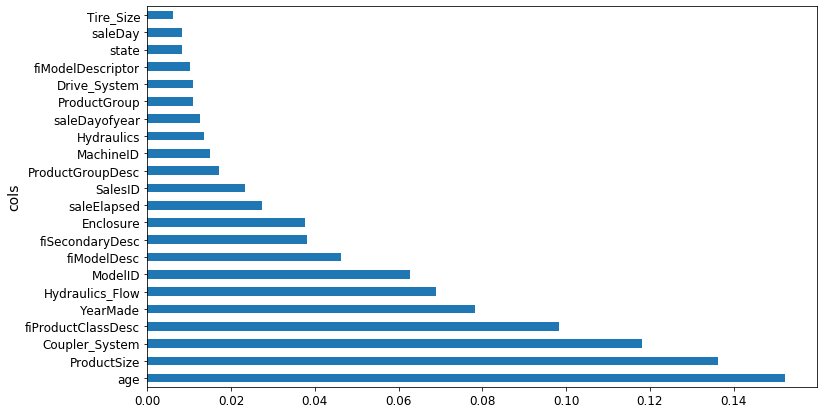

In [232]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [238]:
from treeinterpreter import treeinterpreter as ti

In [239]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [240]:
row = X_valid.values[None,0]; row

array([[      1999,          0,          5,         17,        665,          0, 1284595200,          0,
                 1,       3232,          0,    4364751,    2300944,          0,          0,          4,
                 4,         12,         16,         35,        259,         11]])

In [241]:
prediction, bias, contributions = ti.predict(m, row)

In [252]:
prediction[0], bias[0]

(array([9.35116]), 10.104875170473134)

In [253]:
idxs = np.argsort(contributions[0])

In [260]:
pd.concat(
    [pd.DataFrame(contributions[0]), 
     pd.DataFrame(contributions[0][idxs]),
     pd.DataFrame(idxs)], 
    axis=1
)

,0,0,0
0,0.086447,-0.532534,2
1,0.055331,-0.143669,21
2,-0.532534,-0.135140,3
3,-0.135140,-0.054372,5
4,0.052565,-0.031183,11
5,-0.054372,-0.028710,9
6,-0.021702,-0.021702,6
7,0.028869,-0.017291,8
8,-0.017291,-0.012485,10
9,-0.028710,-0.009805,12


In [261]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.5325343199487792),
 ('age', 11, -0.1436692879560631),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.13514036930128465),
 ('fiSecondaryDesc', nan, -0.05437205803786589),
 ('SalesID', 4364751, -0.03118298502671162),
 ('fiModelDesc', 'KX1212', -0.02870953485388683),
 ('saleElapsed', 1284595200, -0.021701636474191054),
 ('Enclosure', 'EROPS', -0.017290971959764746),
 ('fiModelDescriptor', nan, -0.012484805932491173),
 ('MachineID', 2300944, -0.009804528239615973),
 ('Tire_Size', nan, -0.009277346722163227),
 ('state', 'Ohio', -0.005209964873548722),
 ('saleDayofyear', 259, -0.0029647087471879273),
 ('saleDay', 16, -0.0006616907984932308),
 ('ProductGroup', 'TEX', 0.001915415915308305),
 ('Drive_System', nan, 0.004480746006129177),
 ('Hydraulics', 'Standard', 0.00792070076998148),
 ('ProductGroupDesc', 'Track Excavators', 0.013761464955578662),
 ('Hydraulics_Flow', nan, 0.028868842913152372),
 ('ModelID', 665, 0.05256526439

In [265]:
contributions[0].sum(), bias[0], contributions[0].sum() + bias[0], prediction[0]

(-0.7537133313201085, 10.104875170473134, 9.351161839153026, array([9.35116]))

# Extrapolation

In [268]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [269]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [270]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
11,SalesID,0.789504
6,saleElapsed,0.153361
12,MachineID,0.049774
0,YearMade,0.001884
4,ModelID,0.001328
20,saleDayofyear,0.001226
8,Enclosure,0.000878
9,fiModelDesc,0.000661
1,Coupler_System,0.000577
21,age,0.000270


In [271]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [272]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+06,1206.796148
std,595.627288,1.803913e+05,430.850552
min,1139.246000,6.009984e+05,0.000000
25%,1413.348000,9.666432e+05,1087.016000
50%,1632.093000,1.134605e+06,1273.859000
75%,2210.453000,1.234138e+06,1458.661000
max,4364.741000,1.325117e+06,2313.821000


In [273]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+06,1578.049709
std,836.899608,2.497808e+04,589.497173
min,4364.751000,1.174522e+06,0.830000
25%,4408.580750,1.309219e+06,1271.225250
50%,6272.538500,1.316045e+06,1825.317000
75%,6291.792250,1.321402e+06,1907.858000
max,6333.342000,1.325203e+06,2486.330000


In [274]:
x.drop(feats, axis=1, inplace=True)

In [275]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9787996260517295

In [276]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
18,age,0.232694
0,YearMade,0.187966
17,saleDayofyear,0.152242
4,ModelID,0.079836
8,fiModelDesc,0.064519
15,saleDay,0.058830
16,state,0.056777
3,fiProductClassDesc,0.033378
5,fiSecondaryDesc,0.023872
7,Enclosure,0.021715


In [277]:
feats=['age', 'YearMade', 'saleDayofyear']

In [280]:
(X_train[feats]).describe()

,age,YearMade,saleDayofyear
count,389125.000000,389125.000000,389125.000000
mean,14.533921,1897.836366,177.640249
std,15.107140,293.277183,103.249389
min,-12.000000,1000.000000,2.000000
25%,5.000000,1984.000000,84.000000
50%,9.000000,1995.000000,166.000000
75%,16.000000,2000.000000,270.000000
max,61.000000,2012.000000,365.000000


In [281]:
(X_valid[feats]).describe()

,age,YearMade,saleDayofyear
count,12000.000000,12000.000000,12000.000000
mean,13.153917,1941.978000,255.770417
std,13.851927,234.918521,82.982391
min,-2.000000,1000.000000,33.000000
25%,6.000000,1997.000000,207.000000
50%,8.000000,2003.000000,266.000000
75%,14.000000,2005.000000,335.000000
max,61.000000,2013.000000,364.000000


In [282]:
set_rf_samples(50000)

In [283]:
feats=['SalesID', 'saleElapsed', 'MachineID', 
       'age', 'YearMade', 'saleDayofyear']

In [284]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
get_scores(m, '')

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.207572,0.248804,0.909953,0.889449,0.893427,40,389125,12000


In [286]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    display(get_scores(m, ''))

SalesID


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.208979,0.245798,0.908727,0.892104,0.892634,40,389125,12000


saleElapsed


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.214452,0.254765,0.903884,0.884088,0.886796,40,389125,12000


MachineID


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.206966,0.24672,0.910478,0.891293,0.894827,40,389125,12000


age


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.209097,0.249003,0.908625,0.889272,0.892135,40,389125,12000


YearMade


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.2088,0.250785,0.908884,0.887682,0.892463,40,389125,12000


saleDayofyear


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.209025,0.245359,0.908687,0.892489,0.892711,40,389125,12000


In [287]:
# reset_rf_samples()

In [289]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
get_scores(m, '')

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.209309,0.24045,0.908439,0.896748,0.894055,40,389125,12000


In [290]:
reset_rf_samples()

In [291]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofyear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
get_scores(m, '')

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,,0.138457,0.217011,0.959935,0.915897,0.909363,40,389125,12000


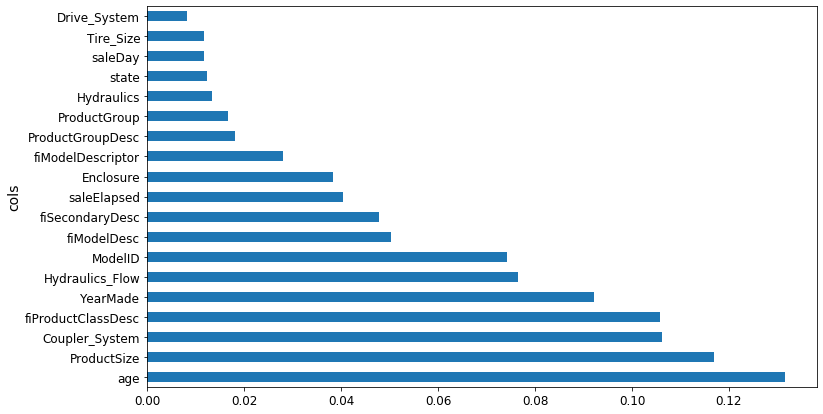

In [292]:
plot_fi(rf_feat_importance(m, X_train));

In [293]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

# Our final model!

In [294]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
get_scores(m, "final")

CPU times: user 4min 19s, sys: 8.19 s, total: 4min 27s
Wall time: 34.2 s


,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,final,0.08017,0.210819,0.986568,0.920628,0.914682,160,389125,12000


In [295]:
tmp = get_scores(m, "final")
tmp

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,final,0.08017,0.210819,0.986568,0.920628,0.914682,160,389125,12000


In [296]:
results

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-slow-dedup,0.125889,0.228204,0.966878,0.906998,0.908479,40,389125,12000
0,one-hot,0.207339,0.254417,0.910154,0.884405,0.892487,40,389125,12000
0,fi,0.207078,0.244760,0.910380,0.893013,0.893957,40,389125,12000
0,baseline-subsample-tuning,0.205304,0.248886,0.911909,0.889376,0.894985,40,389125,12000


In [297]:
results = pd.concat([tmp, results])
results[::-1]

,config,rmse_train,rmse_dev,r2_train,r2_dev,r2_oob,n_trees,train_size,dev_size
0,baseline-subsample-tuning,0.205304,0.248886,0.911909,0.889376,0.894985,40,389125,12000
0,fi,0.207078,0.244760,0.910380,0.893013,0.893957,40,389125,12000
0,one-hot,0.207339,0.254417,0.910154,0.884405,0.892487,40,389125,12000
0,baseline-slow-dedup,0.125889,0.228204,0.966878,0.906998,0.908479,40,389125,12000
0,final,0.080170,0.210819,0.986568,0.920628,0.914682,160,389125,12000


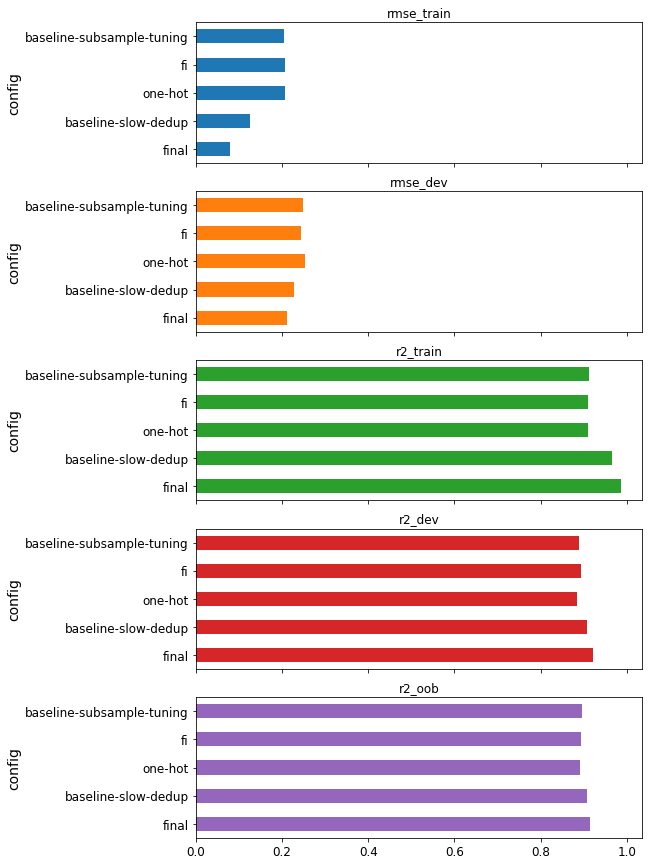

In [298]:
cols = results.columns[:6]
results[cols].plot.barh(
    x='config',
    subplots=True,
    # rot=90,
    # ylim=(0,1),
    # title=['']*4,
    legend=False,
    figsize=(8,3*results.shape[0])
);